## Generate the pkl files

Before you start, copy the script in [this script](https://github.com/ramp-kits/supernovae/blob/master/utils/serialize_lsst_sn_sims.py) to your local directory.


Choose a model to validate. In this example, we will work with MODEL01.
Using an environment with Python3, do in the command line

```
>> python serialize_lsst_sn_sims.py <LSST_sim_dir> --timed
```

where <LSST_sim_dir> is the directory where the FITS files for the model you will analyze are located.

In my case that was

```
>> python serialize_lsst_sn_sim.py ../../data/PLASTICC_2018-02-10/LSST_DDF_MODEL01/ --timed
```

This will create in your local directory a file named `LSST_DDF_MODEL01_train.pkl` which will be used from now on as the data source.

## Read the data

The functions bellow will convert the pkl file into pandas data frames

In [4]:
import gzip
import pickle
import pandas as pd
import numpy as np
from matplotlib import gridspec

LSST_FILTERS = 'ugrizY'


def read_data(filename):
    """Read data from pickled file to a pandas dataframe"""
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f)

    X = to_dataframe(data)
    y = pd.get_dummies(X.type == 0, prefix='SNIa', drop_first=True)
    X = X.drop(columns=['type'])

    return X, y


def to_dataframe(data):
    """Converts from a python dictionary to a pandas dataframe"""
    for idx in data:
        sn = data[idx]
        for filt in LSST_FILTERS:
            sn['mjd_%s' % filt] = np.array(sn[filt]['mjd'])
            sn['fluxcal_%s' % filt] = np.array(sn[filt]['fluxcal'])
            sn['fluxcalerr_%s' % filt] = np.array(sn[filt]['fluxcalerr'])
            del sn[filt]
        sn.update(sn['header'])
        del sn['header']

    return pd.DataFrame.from_dict(data, orient='index')

In [5]:
Xddf, yddf = read_data('LSST_DDF_MODEL50_train.pkl')
print(len(Xddf))

1


Now you can use the data doing

In [10]:
X, y = read_data('LSST_WFD_MODEL50_train.pkl')
X.update(Xddf)

The `X` contain the data itself. You can take a look at what IDs are present in X by using

In [11]:
len(X.index[:100])

27

In [12]:
# Get one supernovae - the first in the list
X.iloc[0]

mjd_u           [59997.344, 60027.234, 60080.109, 60140.094, 6...
fluxcal_u       [-1.49492, -1.72271, -7.35477, -3.08208, 17.0794]
fluxcalerr_u        [11.0652, 9.15771, 8.63604, 6.30566, 10.6057]
mjd_g                [60000.312, 60022.328, 60057.168, 60146.047]
fluxcal_g               [2.30743, -0.0355194, -1.02952, 0.678349]
fluxcalerr_g                 [2.15551, 1.62585, 2.60081, 1.79912]
mjd_r           [59991.34, 60020.266, 60031.305, 60059.297, 60...
fluxcal_r       [-2.19837, 1.641, 176.132, -2.90303, 1.8967, -...
fluxcalerr_r    [3.5398, 3.2277, 2.30575, 2.67977, 3.4684, 5.4...
mjd_i           [59978.367, 60025.395, 60030.391, 60032.25, 60...
fluxcal_i       [27.8802, -35.8221, 449.211, 174.037, 17.9706,...
fluxcalerr_i    [36.3881, 28.3949, 6.02156, 2.83746, 4.38196, ...
mjd_z           [60008.402, 60041.348, 60101.273, 60121.984, 6...
fluxcal_z       [-3.83673, 50.9634, 7.04183, 11.3088, -7.13192...
fluxcalerr_z    [35.4894, 22.6455, 24.2734, 17.4427, 12.9258, ...
mjd_Y     

You can choose one specific SN through its ID. For example, if you wish to access the SN 1618,

In [13]:
X.loc[3100313]

mjd_u           [59997.344, 60027.234, 60080.109, 60140.094, 6...
fluxcal_u       [-1.49492, -1.72271, -7.35477, -3.08208, 17.0794]
fluxcalerr_u        [11.0652, 9.15771, 8.63604, 6.30566, 10.6057]
mjd_g                [60000.312, 60022.328, 60057.168, 60146.047]
fluxcal_g               [2.30743, -0.0355194, -1.02952, 0.678349]
fluxcalerr_g                 [2.15551, 1.62585, 2.60081, 1.79912]
mjd_r           [59991.34, 60020.266, 60031.305, 60059.297, 60...
fluxcal_r       [-2.19837, 1.641, 176.132, -2.90303, 1.8967, -...
fluxcalerr_r    [3.5398, 3.2277, 2.30575, 2.67977, 3.4684, 5.4...
mjd_i           [59978.367, 60025.395, 60030.391, 60032.25, 60...
fluxcal_i       [27.8802, -35.8221, 449.211, 174.037, 17.9706,...
fluxcalerr_i    [36.3881, 28.3949, 6.02156, 2.83746, 4.38196, ...
mjd_z           [60008.402, 60041.348, 60101.273, 60121.984, 6...
fluxcal_z       [-3.83673, 50.9634, 7.04183, 11.3088, -7.13192...
fluxcalerr_z    [35.4894, 22.6455, 24.2734, 17.4427, 12.9258, ...
mjd_Y     

The y holds the IDs in crescent order

In [15]:
y[:5]

""
3100313
4824864
11273519
26343932
34926064


## Plotting the Light curves

You can use the utility bellow to plot one (or a few) light curves

In [19]:
#Plot the data
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

LSST_FILTERS = 'ugrizY'

def plot_lightcurves(idx, X):    
    
    flux = []
    for f in LSST_FILTERS:
        if len(X.iloc[idx]['fluxcal_' + f]) > 0:
            flux.append(max(X.iloc[idx]['fluxcal_' + f]))
            
    for id_f, f in enumerate(LSST_FILTERS):
        
        
        ax = axes[id_f // 3, id_f % 3]
        ax.errorbar(X.iloc[idx]['mjd_%s' % f] - X.iloc[idx]['pkmjd'], 
                    X.iloc[idx]['fluxcal_%s' % f]/max(flux), 
                    X.iloc[idx]['fluxcalerr_%s' % f]/max(flux), 
                    fmt='o-')
        ax.set_xlabel('MJD')
        ax.set_ylabel('Calibrated flux')
        ax.set_title('%s-band' % f)

The functionality bellow will plot light curves in sequence, order by ID

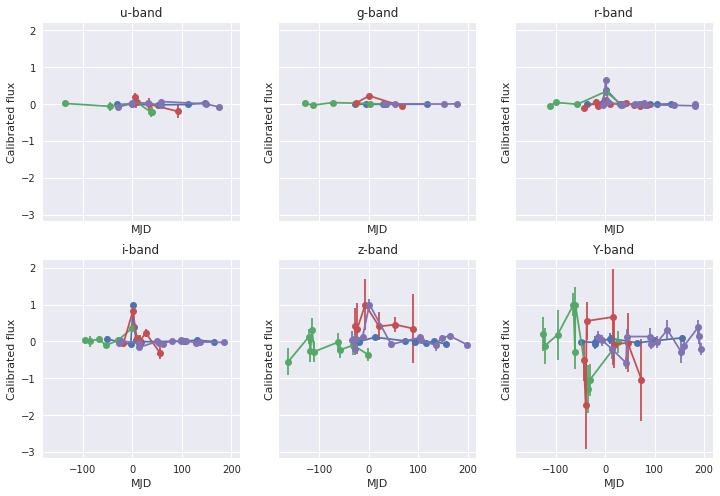

In [22]:
# set the number of light curves to plot
nplots = 4

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
for i in range(nplots):
    plot_lightcurves(i, X)

If you wish to plot one specific light curve, e.g. again SN 1618,

In [31]:
def plot_lightcurves_id(idx, X):    
    
    flux = []
    for f in LSST_FILTERS:
        if len(X.loc[idx]['fluxcal_' + f]) > 0:
            flux.append(max(X.loc[idx]['fluxcal_' + f]))
            
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))        
            
    for id_f, f in enumerate(LSST_FILTERS):
        
        
        ax = axes[id_f // 3, id_f % 3]
        ax.errorbar(X.loc[idx]['mjd_%s' % f] - X.iloc[idx]['pkmjd'], 
                    X.loc[idx]['fluxcal_%s' % f]/max(flux), 
                    X.loc[idx]['fluxcalerr_%s' % f]/max(flux), 
                    fmt='o')
        ax.set_xlabel('MJD')
        ax.set_ylabel('Calibrated flux')
        ax.set_title('%s-band' % f)

In [33]:
#plot_lightcurves_id(3100313, X)

## Example of population tests

Bellow are just a few examples I could quickly think of. 
Feel free to add as much as you want

### Flux values

Check the minimum and maximum values for all filters

In [26]:
max_flux = {}
min_flux = {}

# for each filter
for f in LSST_FILTERS:
    max_flux[f] = []
    min_flux[f] = []
    
    # get the flux values
    for indx in range(len(X)):
        if len(X.iloc[indx]['fluxcal_' + f]) > 0:
            max_flux[f].append(max(X.iloc[indx]['fluxcal_' + f]))
            min_flux[f].append(min(X.iloc[indx]['fluxcal_' + f]))                   

After this information is gathered we can check the the distribution of its values

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))     
for id_f, f in enumerate(LSST_FILTERS):        
    ax = axes[id_f // 3, id_f % 3]
    ax.hist(max_flux[f])
    ax.set_xlabel('Max flux')
    ax.set_ylabel('Number of objects')
    ax.set_title('%s-band' % f)

In [27]:
for f in LSST_FILTERS:
    print(max(max_flux[f]))

78.8655
50.7231
1146.55
449.211
401.923
621.69


Same thing for minimum values

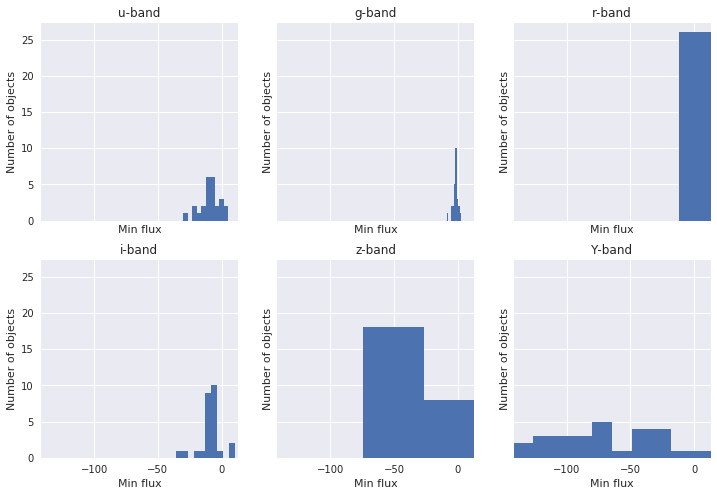

In [28]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))     
for id_f, f in enumerate(LSST_FILTERS):        
    ax = axes[id_f // 3, id_f % 3]
    ax.hist(min_flux[f])
    ax.set_xlim(min(min_flux[f]), max(min_flux[f]))
    ax.set_xlabel('Min flux')
    ax.set_ylabel('Number of objects')
    ax.set_title('%s-band' % f)

In [29]:
for f in LSST_FILTERS:
    print(min(min_flux[f]), max(min_flux[f]))

-29.9114 5.41142
-8.56872 2.36192
-11.7326 1146.55
-35.8221 10.396
-74.255 401.923
-141.714 12.8164


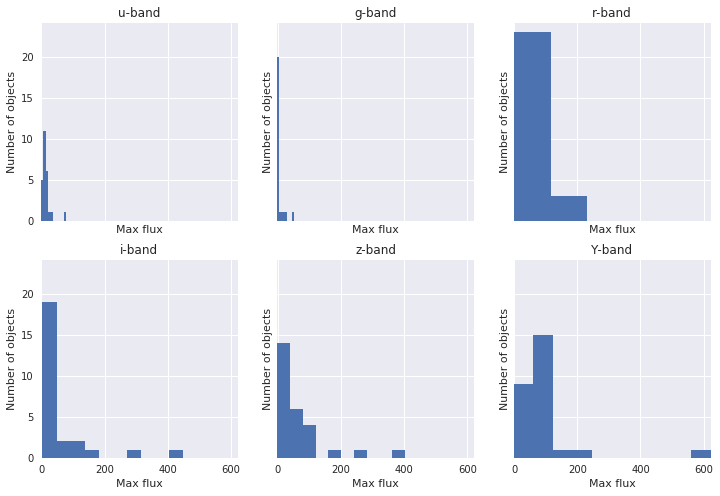

In [30]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))     
for id_f, f in enumerate(LSST_FILTERS):        
    ax = axes[id_f // 3, id_f % 3]
    ax.hist(max_flux[f])
    ax.set_xlim(min(max_flux[f]), max(max_flux[f]))
    ax.set_xlabel('Max flux')
    ax.set_ylabel('Number of objects')
    ax.set_title('%s-band' % f)

## Do not consider after this - SNIa examples

We are going to plot this against other simulations.

Suppose we wish to compare our pet project SN 1618 from the non-ideal simuations. We can check its redshift:

In [73]:
z1618 = X.z[1618]
z1618

1.1337954998016357

now which ideal simulations are close to it in redshift

In [137]:
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - z1618) <= 0.001] 
neighbors[:10]

[741, 892, 1694, 1791, 1945, 2099, 2339, 3118, 3244, 3391]

Plot them all

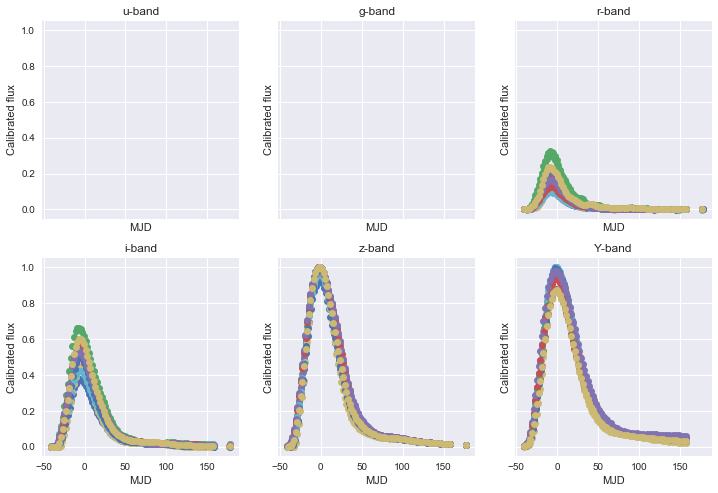

In [138]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
for i in neighbors:
    plot_lightcurves(i, X1)

Superimpose the non-ideal light curve.

In [148]:
snid = 1618

def plot_lightcurves_ideal_compare(snid, X, neighbors, X1):  
    
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8)) 
    
    for idx in neighbors:
        flux = []
        for f in LSST_FILTERS:
            if len(X1.iloc[idx]['fluxcal_' + f]) > 0:
                flux.append(max(X1.iloc[idx]['fluxcal_' + f]))
   
        for id_f, f in enumerate(LSST_FILTERS):
            ax = axes[id_f // 3, id_f % 3]
            ax.errorbar(X1.iloc[idx]['mjd_%s' % f] - X1.iloc[idx]['pkmjd'], 
                        X1.iloc[idx]['fluxcal_%s' % f]/max(flux), 
                        X1.iloc[idx]['fluxcalerr_%s' % f]/max(flux), 
                        fmt='o')
            ax.set_xlabel('MJD')
            ax.set_ylabel('Calibrated flux')
            ax.set_title('%s-band' % f)
    
    flux2 = []
    for f in LSST_FILTERS:
        if len(X.loc[snid]['fluxcal_' + f]) > 0:
            flux2.append(max(X.loc[snid]['fluxcal_' + f]))
    
    for id_f, f in enumerate(LSST_FILTERS):
        ax = axes[id_f // 3, id_f % 3]
        ax.errorbar(X.loc[snid]['mjd_%s' % f] - X.loc[snid]['pkmjd'], 
                    X.loc[snid]['fluxcal_%s' % f]/max(flux), 
                    X.loc[snid]['fluxcalerr_%s' % f]/max(flux), 
                    fmt='o', color='black')
        ax.set_xlabel('MJD')
        ax.set_ylabel('Calibrated flux')
        ax.set_title('%s-band' % f)

In the plot bellow, the black points corresponto the realistic light curve and the other colors to perfect simulations (high cadence and no noise)

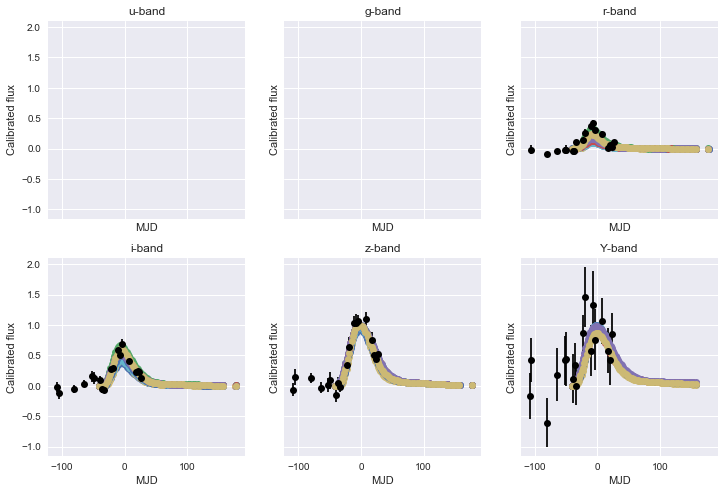

In [149]:
plot_lightcurves_ideal_compare(snid, X, neighbors, X1)